# MPLLayout Demo

`mpllayout` models axes and other elements in figures as geometric primitives which can be constrained relative to each other. 
This gives a flexible way to precisely position figure elements.

The following demo produces Figure 1  from the paper "Ten Simple Rules for Better Figures" (Rougier NP, Droettboom M, Bourne PE (2014) Ten Simple Rules for Better Figures. PLOS Computational Biology 10(9): e1003833. https://doi.org/10.1371/journal.pcbi.1003833).
This figure is itself, a remake of one originally published in the [New York Times](https://archive.nytimes.com/www.nytimes.com/imagepages/2007/07/29/health/29cancer.graph.web.html?action=click&module=RelatedCoverage&pgtype=Article&region=Footer).

The below two sections illustrate how to create the above figure with a `Grid` type constraint as well as more basic constraints.

In [1]:
# Import the relevant packages

import matplotlib.pyplot as plt
import numpy as np

from mpllayout.solver import solve
from mpllayout.layout import Layout
from mpllayout import geometry as geo
from mpllayout.matplotlibutils import subplots
from mpllayout import ui

In [2]:
def refresh_ax(ax):
    ax.clear()
    ax.set_aspect(1)
    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 8)
    return ax


def plot_layout(ax, layout):
    ax = refresh_ax(ax)

    prim_tree_n, solve_info = solve(
        layout.root_prim, layout.constraints, layout.constraint_graph, max_iter=50
    )
    ui.plot_prims(ax, prim_tree_n)
    return solve_info

### Create the layout with `Grid` constraints


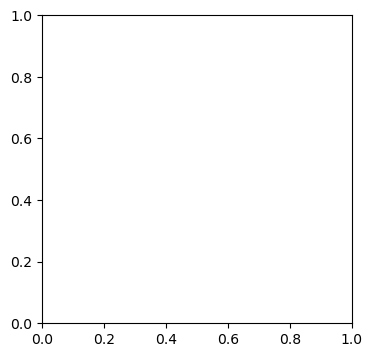

In [3]:
# Use this figure to visualize the layout
fig_layout, ax_layout = plt.subplots(1, 1, figsize=(4, 4))

First create a `Layout` object which is used to track geometric primitives and any constraints on those primitives

In [4]:
layout = Layout()

#### Add all the `Figure` and `Axes` elements

`Figure` and `Axes` elements are represented by `Quadrilateral` primitives

In [5]:
# This adds a box called 'Figure' to the layout
# The box is initially a unit square with the lower left corner at (1, 1) but
# we'll constrain the size and position later
# The `geo.Box` constraint ensure that the quadrilateral sides and tops/bottom are
# aligned with x/y axes
xmin, xmax = (1, 2)
ymin, ymax = (1, 2)
verts = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
layout.add_prim(
    geo.Quadrilateral.from_std(children=[geo.Point.from_std(vert) for vert in verts]), "Figure"
)
layout.add_constraint(geo.Box.from_std({}), ("Figure",))

# This adds a box called 'AxesLeft' to the layout
xmin, xmax = (1.5, 2)
ymin, ymax = (1, 2.4)
verts = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
layout.add_prim(
    geo.Axes.from_std(children=[geo.Quadrilateral.from_std(children=[geo.Point.from_std(vert) for vert in verts])]), "AxesLeft"
)
layout.add_constraint(geo.Box.from_std({}), ("AxesLeft/Frame",))

# This adds a box called 'AxesMid' to the layout
# We'll use this box to place labels
xmin, xmax = (1.2, 2)
ymin, ymax = (2, 3)
verts = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
layout.add_prim(
    geo.Axes.from_std(children=[geo.Quadrilateral.from_std(children=[geo.Point.from_std(vert) for vert in verts])]), "AxesMid"
)
layout.add_constraint(geo.Box.from_std({}), ("AxesMid/Frame",))

# This adds a box called 'AxesRight' to the layout
xmin, xmax = (1.2, 2)
ymin, ymax = (2, 3)
verts = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
layout.add_prim(
    geo.Axes.from_std(children=[geo.Quadrilateral.from_std(children=[geo.Point.from_std(vert) for vert in verts])]), "AxesRight"
)
layout.add_constraint(geo.Box.from_std({}), ("AxesRight/Frame",))

#### Fix the Figure dimensions and position

In [6]:
## Set the figure dimensions

# Fix the bottom left point of 'Figure' to the origin
layout.add_constraint(geo.PointLocation.from_std({'location': np.array([0, 0])}), ("Figure/Line0/Point0",))

# Set the 'Figure' width and height
fig_width, fig_height = (12, 7)

layout.add_constraint(geo.Length.from_std((fig_height,)), ("Figure/Line1",))

layout.add_constraint(geo.Length.from_std((fig_width,)), ("Figure/Line0",))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


{'abs_errs': [150.8476052179815, 5144.5967832766, 1250.1128973937405, 279.5517423416499, 45.93848794226153, 2.7730891309097974, 0.013097835789887066, 2.9780849786220674e-07], 'rel_errs': [1.0, 34.10459699272275, 8.287257166511008, 1.8532063663701204, 0.30453574570095676, 0.018383381870083784, 8.682826466459385e-05, 1.9742341778105143e-09]}


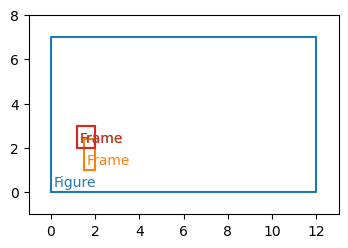

In [7]:
solve_info = plot_layout(ax_layout, layout)
print(solve_info)
fig_layout

In [8]:
## Set top/bottom and left/right margins
margin_top, margin_bottom = (0.5, 0.5)
margin_left, margin_right = (0.5, 0.5)

# Set the top/bottom margins
layout.add_constraint(
    geo.YDistance.from_std((margin_top,)), ("AxesRight/Frame/Line1/Point1", "Figure/Line1/Point1")
)

layout.add_constraint(
    geo.YDistance.from_std((margin_bottom,)), ("Figure/Line0/Point0", "AxesRight/Frame/Line0/Point0")
)

# Set the left/right margins
layout.add_constraint(
    geo.XDistance.from_std((margin_left,)), ("Figure/Line0/Point0", "AxesLeft/Frame/Line0/Point0")
)

layout.add_constraint(
    geo.XDistance.from_std((margin_right,)), ("AxesRight/Frame/Line0/Point1", "Figure/Line0/Point1")
)

{'abs_errs': [150.8567201022215, 5144.5967832766, 1250.1128973937418, 279.55174234164997, 45.93848794226179, 2.7730891309097974, 0.013097835789887066, 2.978084978622078e-07], 'rel_errs': [1.0, 34.10253636556985, 8.286756443774314, 1.8530943941524376, 0.3045173454065127, 0.018382271131380388, 8.682301843107743e-05, 1.9741148929952264e-09]}


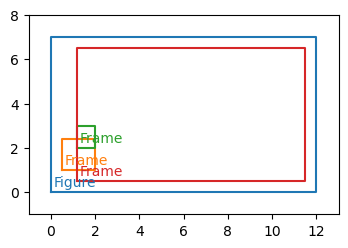

In [9]:
solve_info = plot_layout(ax_layout, layout)
print(solve_info)
fig_layout

#### Constrain the `Axes` in a grid format

This ensures the axes must lie on a rectilinear grid.

In [10]:
constants = {'shape': (1, 3), 'horizontal_margins': [0, 0], 'vertical_margins': [], 'widths': [0.25, 1], 'heights': []}
layout.add_constraint(
    geo.Grid.from_std({**constants}), ("AxesLeft/Frame", "AxesMid/Frame", "AxesRight/Frame")
)

{'abs_errs': [150.86388548668836, 6719.105333701778, 1652.3191322798718, 388.45680547614205, 79.84245833952157, 11.470907095902831, 0.34159559387234073, 0.00011527514505786098, 2.7460251342478604e-12], 'rel_errs': [1.0, 44.537533366755596, 10.952383514115882, 2.574882678004591, 0.5292350656484089, 0.0760348115050701, 0.0022642635298060236, 7.641003324684516e-07, 1.8202004577763304e-14]}


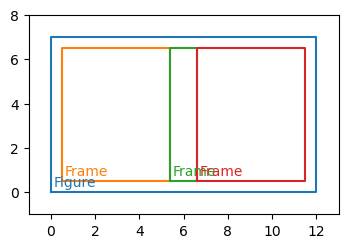

In [11]:
solve_info = plot_layout(ax_layout, layout)
print(solve_info)
fig_layout

### Create the layout without `Grid` constraints

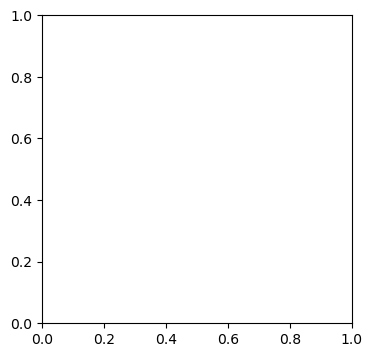

In [12]:
fig_layout, ax_layout = plt.subplots(1, 1, figsize=(4, 4))

First, we create a `Layout` object which is used to track geometric primitives in the layout and any constraints between those primitives

In [14]:
layout = Layout()

#### Add geometric primitives to represent figure elements

Next we add three boxes representing the figure, and left and right axes

In [15]:
# This adds a box called 'Figure' to the layout
# The box is initially a unit square with the lower left corner at (1, 1) but
# we'll constrain the size and position later
# The `geo.Box` constraint ensure that the quadrilateral sides and tops/bottom are
# aligned with x/y axes
xmin, xmax = (1, 2)
ymin, ymax = (1, 2)
verts = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
layout.add_prim(
    geo.Quadrilateral.from_std(children=[geo.Point.from_std(vert) for vert in verts]), "Figure"
)
layout.add_constraint(geo.Box.from_std({}), ("Figure",))

# This adds a box called 'AxesLeft' to the layout
xmin, xmax = (1.5, 2)
ymin, ymax = (1, 2.4)
verts = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
layout.add_prim(
    geo.Axes.from_std(children=[geo.Quadrilateral.from_std(children=[geo.Point.from_std(vert) for vert in verts])]), "AxesLeft"
)
layout.add_constraint(geo.Box.from_std({}), ("AxesLeft/Frame",))

# This adds a box called 'AxesMid' to the layout
# We'll use this box to place labels
xmin, xmax = (1.2, 2)
ymin, ymax = (2, 3)
verts = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
layout.add_prim(
    geo.Axes.from_std(children=[geo.Quadrilateral.from_std(children=[geo.Point.from_std(vert) for vert in verts])]), "AxesMid"
)
layout.add_constraint(geo.Box.from_std({}), ("AxesMid/Frame",))

# This adds a box called 'AxesRight' to the layout
xmin, xmax = (1.2, 2)
ymin, ymax = (2, 3)
verts = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
layout.add_prim(
    geo.Axes.from_std(children=[geo.Quadrilateral.from_std(children=[geo.Point.from_std(vert) for vert in verts])]), "AxesRight"
)
layout.add_constraint(geo.Box.from_std({}), ("AxesRight/Frame",))

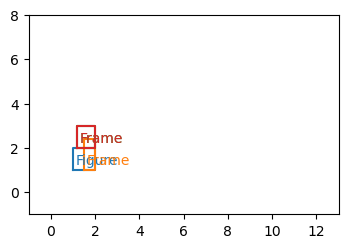

In [16]:
plot_layout(ax_layout, layout)
fig_layout

#### Add constraints between geometric primitives

##### Fix the figure dimensions and position

In [17]:
# Fix the bottom left point of 'Figure' to the origin
layout.add_constraint(geo.PointLocation.from_std({'location': np.array([0, 0])}), ("Figure/Line0/Point0",))

# Set the 'Figure' width and height
fig_width, fig_height = (12, 7)

layout.add_constraint(geo.Length.from_std((fig_height,)), ("Figure/Line1",))

layout.add_constraint(geo.Length.from_std((fig_width,)), ("Figure/Line0",))

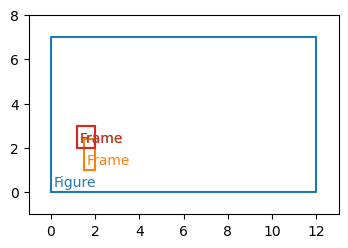

In [18]:
plot_layout(ax_layout, layout)
fig_layout

##### Set top/bottom and left/right margins

In [19]:
margin_top, margin_bottom = (0.5, 0.5)
margin_left, margin_right = (0.5, 0.5)

# Set the top/bottom margins
layout.add_constraint(
    geo.DirectedDistance.from_std((margin_top, np.array([0, 1]))),
    ("AxesRight/Frame/Line1/Point1", "Figure/Line1/Point1"),
)

layout.add_constraint(
    geo.DirectedDistance.from_std((margin_bottom, np.array([0, -1]))),
    ("AxesRight/Frame/Line0/Point0", "Figure/Line0/Point0"),
)

# Set the left/right margins
layout.add_constraint(
    geo.DirectedDistance.from_std((margin_right, np.array([1, 0]))),
    ("AxesRight/Frame/Line1/Point1", "Figure/Line1/Point1"),
)

layout.add_constraint(
    geo.DirectedDistance.from_std((margin_left, np.array([-1, 0]))),
    ("AxesLeft/Frame/Line0/Point0", "Figure/Line0/Point0"),
)

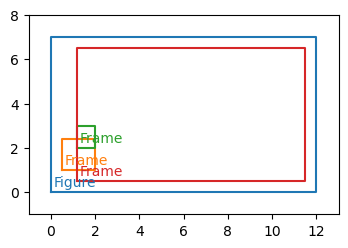

In [20]:
plot_layout(ax_layout, layout)
fig_layout

##### Set the margin between left/right axes


In [21]:
margin_inter = 2
layout.add_constraint(
    geo.DirectedDistance.from_std((margin_inter, np.array([1, 0]))),
    ("AxesLeft/Frame/Line0/Point1", "AxesRight/Frame/Line0/Point0"),
)

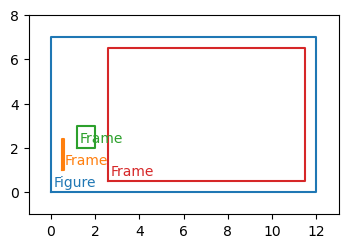

In [22]:
plot_layout(ax_layout, layout)
fig_layout

##### Align `'AxesLeft'`, `'AxesRight'`, and `'AxesMid'`

The code `geo.CollinearLines()` represents a collinear constraint which applies to a set of primitives.
The code `(PrimIdx('AxesLeft', 0), PrimIdx('AxesRight', 1))` indicates the primitives the constraint applies to.

The index object `PrimIdx('AxesLeft', 0)` represents 0th line of the `Quadrilateral` `'AxesLeft'`
This notation is used because the `Quadrilateral` primitive consists of 4 lines which can be be indexed

In [23]:
# Align the bottoms of 'AxesLeft', 'AxesRight', and 'AxesMid'
layout.add_constraint(geo.Collinear.from_std({}), ("AxesLeft/Frame/Line0", "AxesRight/Frame/Line0"))

In [24]:
# Similarly we make the tops of 'AxesLeft', 'AxesRight', and 'AxesMid' line up
layout.add_constraint(geo.Collinear.from_std({}), ("AxesLeft/Frame/Line2", "AxesRight/Frame/Line2"))

In [26]:
# Make sure 'AxesMid' occupies the space between 'AxesLeft' and 'AxesRight'

# This pins the bottom right corner of 'AxesMid' to the bottom left corner of 'AxesLeft'
layout.add_constraint(
    geo.CoincidentPoints.from_std({}), ("AxesLeft/Frame/Line0/Point1", "AxesMid/Frame/Line0/Point0")
)

# This pins the top left corner of 'AxesMid' to the top right corner of 'AxesRight'
layout.add_constraint(
    geo.CoincidentPoints.from_std({}), ("AxesMid/Frame/Line1/Point1", "AxesRight/Frame/Line3/Point0")
)

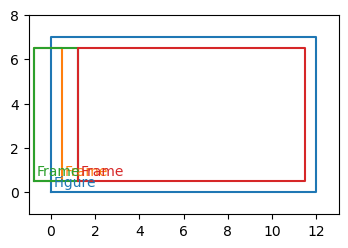

In [27]:
plot_layout(ax_layout, layout)
fig_layout

##### Set relative widths of `'AxesLeft'` and `'AxesRight'`

In [29]:
# This makes the top of 'AxesLeft' 100% the length of the top of 'AxesRight'
layout.add_constraint(geo.RelativeLength.from_std((1.0,)), ("AxesLeft/Frame/Line0", "AxesRight/Frame/Line0"))

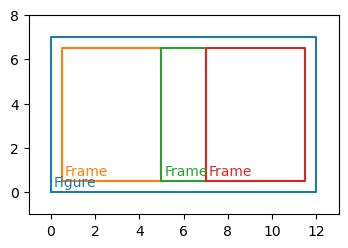

In [30]:
plot_layout(ax_layout, layout)
fig_layout

## Create the Figure from the layout

In [31]:
prim_tree_n, solve_info = solve(
    layout.root_prim, layout.constraints, layout.constraint_graph
)

In [32]:
# The data below is approximated from a New York Times article ()
# and is adapted from the figure-1.py file available at (https://github.com/rougier/ten-rules)

diseases = [
    "Kidney Cancer",
    "Bladder Cancer",
    "Esophageal Cancer",
    "Ovarian Cancer",
    "Liver Cancer",
    "Non-Hodgkin's\nlymphoma",
    "Leukemia",
    "Prostate Cancer",
    "Pancreatic Cancer",
    "Breast Cancer",
    "Colorectal Cancer",
    "Lung Cancer",
]
men_deaths = [
    10000,
    12000,
    13000,
    0,
    14000,
    12000,
    16000,
    25000,
    20000,
    500,
    25000,
    80000,
]
men_cases = [
    30000,
    50000,
    13000,
    0,
    16000,
    30000,
    25000,
    220000,
    22000,
    600,
    55000,
    115000,
]
women_deaths = [
    6000,
    5500,
    5000,
    20000,
    9000,
    12000,
    13000,
    0,
    19000,
    40000,
    30000,
    70000,
]
women_cases = [
    20000,
    18000,
    5000,
    25000,
    9000,
    29000,
    24000,
    0,
    21000,
    160000,
    55000,
    97000,
]

y_diseases = np.arange(len(diseases))

In [33]:
def format_axes(ax):
    """
    Apply the Axes formatting used in "Ten Simple Rules"
    """
    if not ax.xaxis.get_inverted():
        origin_side = "left"
        far_side = "right"
    else:
        origin_side = "right"
        far_side = "left"

    ax.spines[far_side].set_color("none")
    ax.spines[origin_side].set_zorder(10)
    ax.spines["bottom"].set_color("none")

    ax.xaxis.set_ticks_position("top")

    ax.yaxis.set_ticks_position(origin_side)
    ax.yaxis.set_ticks(y_diseases, labels=[""] * len(y_diseases))

    ax.spines["top"].set_position(("data", len(diseases) + 0.25))
    ax.spines["top"].set_color("w")

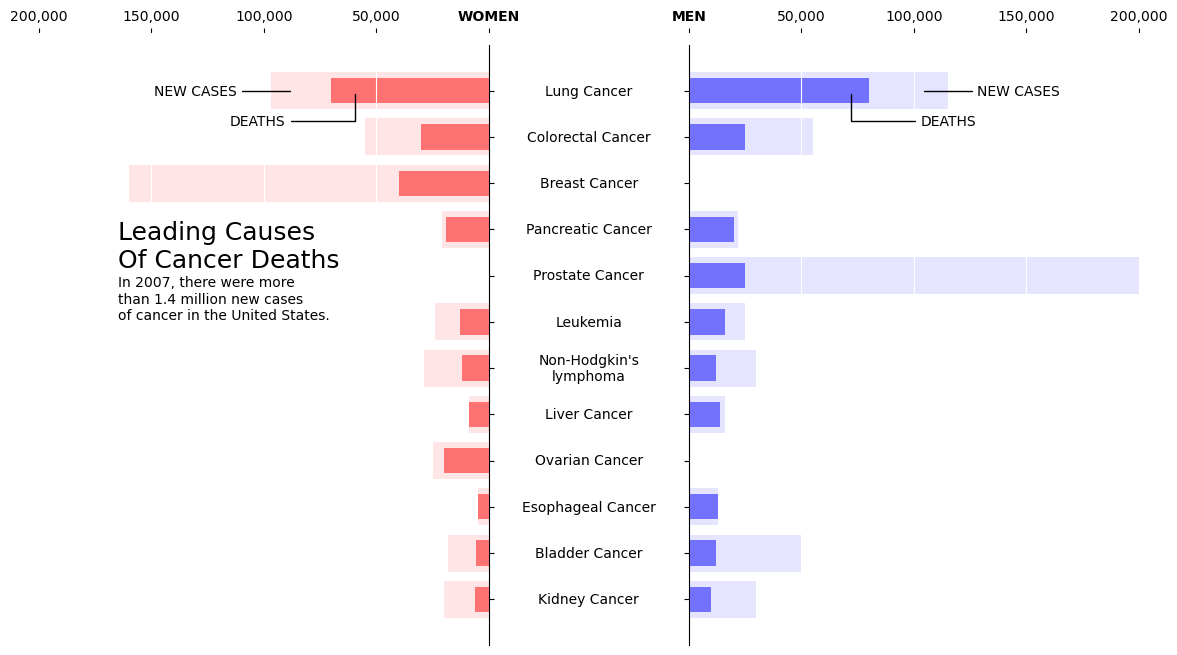

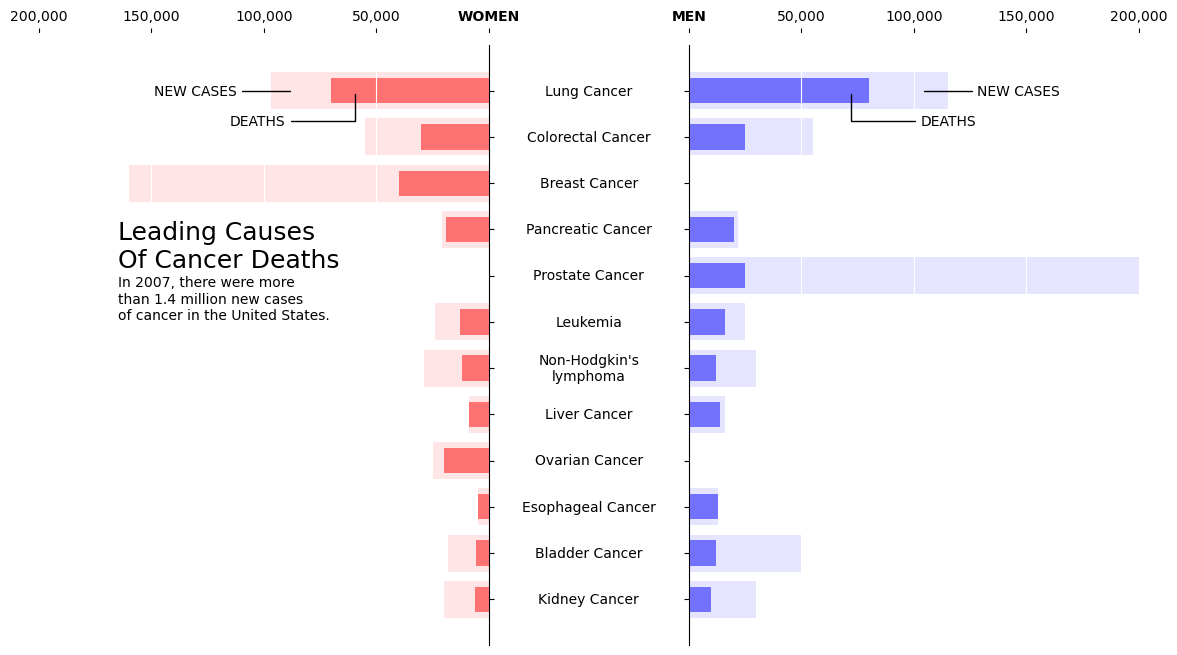

In [34]:
fig, axs = subplots(prim_tree_n)

for ax in axs.values():
    ax.set_xlim(0, 200000)

# Plot the men/womens data
axs["AxesLeft"].barh(y_diseases, women_cases, height=0.8, fc="red", alpha=0.1)
axs["AxesLeft"].barh(y_diseases, women_deaths, height=0.55, fc="red", alpha=0.5)
axs["AxesLeft"].xaxis.set_inverted(True)

axs["AxesRight"].barh(y_diseases, men_cases, height=0.8, fc="blue", alpha=0.1)
axs["AxesRight"].barh(y_diseases, men_deaths, height=0.55, fc="blue", alpha=0.5)

axs_labels = ["AxesLeft", "AxesRight"]
axs_categories = ["women", "men"]
for axs_label, category in zip(axs_labels, axs_categories):
    ax = axs[axs_label]
    format_axes(ax)
    ax.set_xticks(
        [0, 50000, 100000, 150000, 200000],
        [category.upper(), "50,000", "100,000", "150,000", "200,000"],
    )
    ax.grid(which="major", axis="x", color="white")
    ax.get_xticklabels()[0].set_weight("bold")

# Add ylabels to 'AxesMid'
axs["AxesMid"].set_axis_off()
axs["AxesMid"].set_ylim(axs["AxesLeft"].get_ylim())
axs["AxesMid"].set_xlim(-1, 1)

for y, disease_name in zip(y_diseases, diseases):
    axs["AxesMid"].text(0, y, disease_name, ha="center", va="center")

# Add the "NEW CASES" and "DEATHS" annotations
# Devil hides in the details...
arrowprops = {"arrowstyle": "-", "connectionstyle": "angle,angleA=0,angleB=90,rad=0"}

x = women_cases[-1]
y = y_diseases[-1]
axs["AxesLeft"].annotate(
    "NEW CASES",
    xy=(0.9 * x, y),
    xycoords="data",
    ha="right",
    fontsize=10,
    xytext=(-40, -3),
    textcoords="offset points",
    arrowprops=arrowprops,
)

x = women_deaths[-1]
axs["AxesLeft"].annotate(
    "DEATHS",
    xy=(0.85 * x, y),
    xycoords="data",
    ha="right",
    fontsize=10,
    xytext=(-50, -25),
    textcoords="offset points",
    arrowprops=arrowprops,
)

x = men_cases[-1]
axs["AxesRight"].annotate(
    "NEW CASES",
    xy=(0.9 * x, y),
    xycoords="data",
    ha="left",
    fontsize=10,
    xytext=(+40, -3),
    textcoords="offset points",
    arrowprops=arrowprops,
)

x = men_deaths[-1]
axs["AxesRight"].annotate(
    "DEATHS",
    xy=(0.9 * x, y),
    xycoords="data",
    ha="left",
    fontsize=10,
    xytext=(+50, -25),
    textcoords="offset points",
    arrowprops=arrowprops,
)

# Add the caption text
axs["AxesLeft"].text(
    165000, 8.2, "Leading Causes\nOf Cancer Deaths", fontsize=18, va="top"
)
axs["AxesLeft"].text(
    165000,
    7,
    "In 2007, there were more\n"
    "than 1.4 million new cases\n"
    "of cancer in the United States.",
    va="top",
    fontsize=10,
)

fig.savefig("figure-1.svg")
fig